# LDA MODEL
This model takes all the 61 files currently in Task 1. Make sure that the notebook is being run from the 'wrilatinamerica' folder in Github.

First step is importing all the models we use. Notice that the stopwords from spacy must be already downloaded as well as the 'es_core_news_md' dataset of spacy for lemmatization.

In [33]:
# Importing modules
import pandas as pd
import os
from pathlib import Path
os.chdir('..')
import glob
import unidecode
import pathlib

# Load the library with the CountVectorizer method
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.data import load
from nltk.stem import SnowballStemmer
from string import punctuation
import es_core_news_sm
import unidecode
import string

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy
# stop_words = stopwords.words('spanish')
stop_words = spacy.lang.es.stop_words.STOP_WORDS

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

## Run the notebook from the correct location.

With the next cell you can guarantee that you are in the correct folder.

In [15]:
%cd C:\Users\dcalle.MATONE\Documents\GitHub\wrilatinamerica
#     Your_path\GitHub\wrilatinamerica

C:\Users\dcalle.MATONE\Documents\GitHub\wrilatinamerica


In [32]:
spacy.lang.es.stop_words.STOP_WORDS

set

# Define the functions

Below you can find all the needed functions:

### 1. sent_to_words:
This will tokenize the paragraphs. We used this because other tokenizers seemed to chop/crop the words wrongly. This one worked very well.

### 2. make_bigrams and make_trigrams:
This will check for possible unigrams/bigrams/trigrams combinations that arise in the paragraphs just to make sure we do not miss complex expressions that are not expressable in unigrams.

### 3. lemmatization:
This will already lemmatize our tokens using spacy library.

### 4. compute_coherence values:
Defining a start,step, limit (amount of topics used) this function will create several models and return the models and their coherence with different amount of topics so that a best model can be defined.

### 5. format_topic_paragraphs:
This will take the a model, the corpus (as BoW matrix) and the original paragraphs to create a dataframe that relates the most relevant topic to each paragraph, each paragraph to a document and each document to a country.

In [16]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
#         model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)

        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

def format_topics_paragraphs(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
#         try:
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
#         except: print(row)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, topic_info in enumerate(row): #(topic_num, prop_topic)
            topic_num = topic_info[0]
            prop_topic = topic_info[1]
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.DataFrame(data = texts, columns=['Text', 'Country', 'Document'])
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

Now, we load all the documents and create three main structures:

### master_paragraphs: 
This is a list. Each element is related to a document. For each document there is a list of tuples that contain country, paragraph and file name information.

### all_paragraphs:
This is a list with all paragraphs of the files.

In [17]:
countries = ['mexico','peru','chile','guatemala', 'el salvador']
docs_path = Path("src/data/docs")

documents = list()
corpus = list()
all_files = list()
big_files = 0

for country in countries:

    txt_path = docs_path / country.title()
#     print(txt_path)
    files = os.listdir(txt_path)#glob.glob(txt_path)
    files = [file for file in files if '.txt' in file]
    for file in files:
        all_files.append([file,country])
    for elem in files:
        if type(elem) == str:
            file_name = elem.split('/')[-1].split('.')[0]#.lower()
        else: continue 
        open_path = os.path.join(txt_path, file_name + ".txt")
        #os.path.join(txt_path, file_name + "_preprocessed.txt")
#         print(open_path)
        
        try:
            with open(open_path, 'rb') as text:
                decoded = text.read()
                decoded = decoded.decode('UTF-8').replace('\n', ' ')
#                 corpus.append(decoded)     
                
            documents.append((country.title(),file_name,decoded))
            text.close
        except: 
            print("This file must be included locally ", file_name)
            continue
            
master_paragraphs = []
tmp = []
for country, file_name, text in documents:
    # "i" will be the paragraph number according to the split generated by the separator " \r"
    paragraphs = [(country, file_name, i, paragraph) for i,paragraph in enumerate(text.split(" \r ")) if len(paragraph)>20]
    
    # Each element of all_paragraphs is a list of tuples that belongs to a specific document
    master_paragraphs.append(paragraphs)
    tmp.extend(paragraphs)

all_paragraphs = [paragraph[3] for paragraph in tmp]
len(all_paragraphs)

85563

In [18]:
#Here, we tokenize the paragraphs.
data_words_p = list(sent_to_words(all_paragraphs))

The next cell will take each paragraph and validate if it has at least 'threshold' amount of words (in this case 60). If not, it will merge the paragraph with the next one.

This already avoids merging paragraphs between different documents and different countries.

The result are two structures:

### new_data: 
It is a list of lists of tokens. Where each element of the outer list contains a paragraph(s) with at least 60 words.

### new_master_paragraphs:
Given the new arrangement of paragraphs, this will relate each new list of tokens, relate it to a file name and country.

In [19]:
new_data = []
new_master_paragraphs = []
i= 0
j = 0
doc_id = 0
threshold = 60
data = []

while i < len(data_words_p):
    del data
    data = data_words_p[i]
    
    while len(data) < threshold:
        #Extend the list data with the following lists until reach a minimum length
        i += 1
        j += 1
        
        if i >= len(data_words_p): 
            break #Avoid that the last steps crash because of an out-of-index error
        
        if j >= len(master_paragraphs[doc_id]): 
            doc_id += 1
            j = 0
            break #Avoid merging paragraphs from different documents
        
        data.extend(data_words_p[i])
            
    if len(data) < threshold: 
        continue #Ignore those cases between documents that do not reach the threshold of words
    
    country_ = master_paragraphs[doc_id][j][0]
    file_ = master_paragraphs[doc_id][j][1]
    new_master_paragraphs.append((data, country_, file_))
        
    new_data.append(data)
    i += 1 #Avoid repeating paragraphs in each cycle

We can perform a quick check of the sizes of the structures to make sure we are in the correct direction.

In [20]:
print(len(data_words_p),len(master_paragraphs)) #This is the initial amount of paragraphs in total and the amount of documents
len(master_paragraphs[0]) #This is the amount of initial paragraphs in the first document

85563 61


2693

In [21]:
print(len(new_master_paragraphs)) #This is the new total amount of paragraphs after processing them by size
print(len(new_data)) #This is the same as above but the structure is only the list of lists of tokens, which will be used by the LDA
print(new_data[0], len(new_data[0]))

17624
17624
['lista', 'cuadros', 'figurasiv', 'lista', 'anexosv', 'acronimos', 'abreviaturasv', 'antecedentes', 'organizacion', 'proyecto', 'objetivo', 'programa', 'estrategico', 'forestal', 'mexico', 'proceso', 'elaboracion', 'plan', 'recursos', 'naturales', 'marco', 'referencia', 'degradacion', 'recursos', 'manejo', 'forestal', 'plantaciones', 'forestales', 'germoplasma', 'aprovechamiento', 'industria', 'forestal', 'bioenergia', 'servicios', 'ambientales', 'recursos', 'maderables', 'biodiversidad', 'mecanismos', 'financieros', 'marco', 'institucional', 'servicios', 'tecnicos', 'inspeccion', 'vigilancia', 'sistema', 'nacional', 'informacion', 'forestal', 'inventario', 'nacional', 'forestal', 'educacion', 'capacitacion', 'investigacion', 'cultura', 'forestal', 'marco', 'juridico', 'fortalezas', 'debilidades', 'comparativas', 'sector', 'forestal', 'maderable', 'implicaciones', 'sociales'] 68


In [22]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(new_data, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[new_data], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[new_data[0]]])

['lista', 'cuadros', 'figurasiv', 'lista', 'anexosv', 'acronimos', 'abreviaturasv', 'antecedentes', 'organizacion', 'proyecto', 'objetivo', 'programa', 'estrategico', 'forestal', 'mexico', 'proceso', 'elaboracion', 'plan', 'recursos', 'naturales', 'marco', 'referencia', 'degradacion', 'recursos', 'manejo', 'forestal', 'plantaciones', 'forestales', 'germoplasma', 'aprovechamiento', 'industria', 'forestal', 'bioenergia', 'servicios', 'ambientales', 'recursos', 'maderables', 'biodiversidad', 'mecanismos', 'financieros', 'marco', 'institucional', 'servicios', 'tecnicos', 'inspeccion', 'vigilancia', 'sistema', 'nacional', 'informacion', 'forestal', 'inventario', 'nacional', 'forestal', 'educacion', 'capacitacion', 'investigacion', 'cultura', 'forestal', 'marco', 'juridico', 'fortalezas', 'debilidades', 'comparativas', 'sector', 'forestal', 'maderable', 'implicaciones', 'sociales']


In [34]:
added_stopwords = ["ley","casar", "nacion", "republica", "decreto", "pagina", "resolución", "resolucion", "decir", "siguiente", "terminos", "presidente", 
 "decretar", "ministro", "respectivo", "fecho", "caracter", "ano", "secretario", "asamblea", "senado", "deberan", "anexo", "informacion", "enmienda",
 "deberian", "signatario", "inclusive"]

for w in added_stopwords:
    stop_words.add(w)
    
for w in stopwords.words('spanish'):
    stop_words.add(w)

# Remove Stop Words
data_words_nostops_p = remove_stopwords(new_data)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops_p)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download es_core_news_md
nlp = spacy.load('es_core_news_md', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['listo', 'cuadro', 'listo', 'anexosv', 'acronimos', 'antecedente', 'objetivar', 'programar', 'estrategico', 'forestal', 'mexico', 'procesar', 'elaboracion', 'recurso', 'natural', 'recurso', 'manejar', 'forestal', 'plantación', 'forestal', 'germoplasma', 'aprovechamiento', 'forestal', 'servicio', 'ambiental', 'recurso', 'maderable', 'biodiversidad', 'financiero', 'institucional', 'servicio', 'tecnicos', 'forestal', 'inventario', 'nacional', 'forestal', 'cultura', 'forestal', 'marcar', 'juridico', 'fortaleza', 'debilidad', 'comparativo', 'sector', 'forestal', 'maderable', 'implicación', 'social']]


In [35]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 8), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 2), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 3), (32, 1), (33, 2), (34, 1), (35, 1)]]


In [36]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=20, limit=80, step=5)

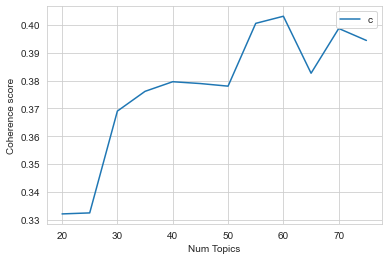

In [37]:
# Show graph
limit=80; start=20; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [38]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 20  has Coherence Value of 0.332
Num Topics = 25  has Coherence Value of 0.3324
Num Topics = 30  has Coherence Value of 0.369
Num Topics = 35  has Coherence Value of 0.3762
Num Topics = 40  has Coherence Value of 0.3796
Num Topics = 45  has Coherence Value of 0.379
Num Topics = 50  has Coherence Value of 0.378
Num Topics = 55  has Coherence Value of 0.4006
Num Topics = 60  has Coherence Value of 0.4032
Num Topics = 65  has Coherence Value of 0.3827
Num Topics = 70  has Coherence Value of 0.3988
Num Topics = 75  has Coherence Value of 0.3945


In [44]:
%pwd

'C:\\Users\\dcalle.MATONE\\Documents\\GitHub'

In [43]:
import pickle
# save the model to disk
optimal_model = model_list[8]
filename = r'par_ext_stop_LDA_60_topic_model.sav'
pickle.dump(optimal_model, open(filename, 'wb'))

In [15]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=10))

[(29, '0.000*"plena_validez" + 0.000*"millones_quetzales" + 0.000*"publicacion_dado" + 0.000*"navidenos" + 0.000*"helecho" + 0.000*"arborescente" + 0.000*"arbolitos" + 0.000*"economico_tecnologico" + 0.000*"acatar" + 0.000*"comision_calificadora"'), (11, '0.000*"plena_validez" + 0.000*"millones_quetzales" + 0.000*"publicacion_dado" + 0.000*"navidenos" + 0.000*"helecho" + 0.000*"arborescente" + 0.000*"arbolitos" + 0.000*"economico_tecnologico" + 0.000*"acatar" + 0.000*"comision_calificadora"'), (24, '0.474*"especie" + 0.135*"arbolar" + 0.104*"plantación" + 0.012*"optimo" + 0.011*"respectivamente" + 0.007*"hongo" + 0.000*"alejos_close" + 0.000*"publicacion_dado" + 0.000*"navidenos" + 0.000*"helecho"'), (4, '0.433*"previo" + 0.169*"ejecutar" + 0.075*"area" + 0.055*"cuadrar" + 0.042*"escenario" + 0.013*"listo" + 0.007*"consideración" + 0.000*"publicacion_dado" + 0.000*"economico_tecnologico" + 0.000*"helecho"'), (8, '0.298*"propietario" + 0.118*"imponer" + 0.090*"preciar" + 0.064*"parcelar

In [27]:
df_topic_sents_keywords = format_topics_paragraphs(ldamodel=optimal_model, corpus=corpus, texts=new_master_paragraphs)

#Without the text of each paragraph to reduce size of the dataframe
df_topic_sents_keywords.drop("Text",axis=1).to_csv(r"src\models\LDA\mod_paragraph_topics_LDA_cut_df.csv") 

#Complete dataframe
df_topic_sents_keywords.drop("Text",axis=1).to_csv(r"src\models\LDA\mod_paragraph_topics_LDA_complete_df.csv") 

# Show
df_topic_sents_keywords.head(10)

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text,Country,Document
0,13.0,0.2476,"desarrollar, nacional, municipal, servicio, pr...","[lista, cuadros, figurasiv, lista, anexosv, ac...",Mexico,CONAFOR_ plan 2025_preprocessed
1,26.0,0.2228,"forestal, manejar, producto, aprovechamiento, ...","[objetivos, del, desarrollo, forestal, sustent...",Mexico,CONAFOR_ plan 2025_preprocessed
2,13.0,0.2121,"desarrollar, nacional, municipal, servicio, pr...","[mecanismos, financieros, fortalecimiento, ins...",Mexico,CONAFOR_ plan 2025_preprocessed
3,4.0,0.2108,"previo, ejecutar, area, cuadrar, escenario, li...","[mecanismos, de, ejecucion, del, plan, conside...",Mexico,CONAFOR_ plan 2025_preprocessed
4,14.0,0.1795,"actividad, casar, personar, formar, siguiente,...","[promocion, manejo, forestal, sustentable, com...",Mexico,CONAFOR_ plan 2025_preprocessed
5,14.0,0.1776,"actividad, casar, personar, formar, siguiente,...","[figura, cuadro, figura, figura, cuadro, figur...",Mexico,CONAFOR_ plan 2025_preprocessed
6,13.0,0.1761,"desarrollar, nacional, municipal, servicio, pr...","[ilce, ine, inegi, inf, inif, inifap, km, peso...",Mexico,CONAFOR_ plan 2025_preprocessed
7,13.0,0.1753,"desarrollar, nacional, municipal, servicio, pr...","[lgeepa, lgvs, mdf, mdl, mds, mfs, nom, ong, o...",Mexico,CONAFOR_ plan 2025_preprocessed
8,21.0,0.2068,"natural, recurso, areas, protegido, empresa, p...","[la, proteccion, ambiental, sustentabilidad, c...",Mexico,CONAFOR_ plan 2025_preprocessed
9,14.0,0.2994,"actividad, casar, personar, formar, siguiente,...","[sin, senales, positivas, individuos, gobierno...",Mexico,CONAFOR_ plan 2025_preprocessed


In [18]:
df_topic_sents_keywords.to_csv(r"src\models\LDA\paragraph_LDA_dataframe.csv")

In [36]:
df_topic_sents_keywords.Topic_Keywords[0]

'desarrollar, nacional, municipal, servicio, programar, accionar, cumplimiento, sector, procesar, proceso'

In [33]:
id2word.token2id

{'acronimos': 0,
 'ambiental': 1,
 'anexosv': 2,
 'antecedente': 3,
 'aprovechamiento': 4,
 'biodiversidad': 5,
 'comparativo': 6,
 'cuadro': 7,
 'cultura': 8,
 'debilidad': 9,
 'elaboracion': 10,
 'estrategico': 11,
 'financiero': 12,
 'forestal': 13,
 'fortaleza': 14,
 'germoplasma': 15,
 'implicación': 16,
 'institucional': 17,
 'inventario': 18,
 'juridico': 19,
 'listo': 20,
 'maderable': 21,
 'manejar': 22,
 'marcar': 23,
 'mexico': 24,
 'nacional': 25,
 'natural': 26,
 'objetivar': 27,
 'plantación': 28,
 'procesar': 29,
 'programar': 30,
 'recurso': 31,
 'sector': 32,
 'servicio': 33,
 'social': 34,
 'tecnicos': 35,
 'actividad': 36,
 'comercial': 37,
 'comunitario': 38,
 'control': 39,
 'desarrollar': 40,
 'disminucion_presion': 41,
 'escenario': 42,
 'especificar': 43,
 'especificos': 44,
 'estrategia': 45,
 'externo': 46,
 'fundamental': 47,
 'general': 48,
 'incendio': 49,
 'industriar': 50,
 'lineamiento': 51,
 'maderable_maderable': 52,
 'mejoramiento': 53,
 'mercar': 54,

In [96]:
# optimal_model[corpus[0]]

In [99]:
other_texts = [["incentivo"]]
other_corpus = [id2word.doc2bow(text) for text in other_texts]
dir(optimal_model[other_corpus])
optimal_model[other_corpus[0]]

([(0, 0.017116833),
  (1, 0.011123905),
  (2, 0.020562228),
  (3, 0.02088204),
  (5, 0.102202125),
  (6, 0.020340405),
  (7, 0.036582906),
  (9, 0.018056888),
  (10, 0.019759485),
  (12, 0.028676951),
  (13, 0.13837014),
  (14, 0.22203435),
  (15, 0.01815286),
  (16, 0.04979276),
  (17, 0.011737122),
  (18, 0.013477402),
  (19, 0.026374223),
  (20, 0.050592277),
  (21, 0.040242467),
  (22, 0.014248697),
  (23, 0.018670807),
  (25, 0.018294793),
  (26, 0.03577598),
  (27, 0.016116865),
  (28, 0.01017653)],
 [(726, [20])],
 [(726, [(20, 0.999951)])])

In [98]:
other_corpus

[[(726, 1)]]

In [8]:
print(loaded_model.get_term_topics(12)) #financiero
print(loaded_model.get_term_topics(249)) #economicas
print(loaded_model.get_term_topics(258)) #imponer
loaded_model.get_term_topics(361)

[(7, 0.056687254)]
[(23, 0.012753866)]
[(8, 0.117592655)]


[]

In [34]:
optimal_model.get_term_topics(726) #incentivo

[(20, 0.06947574)]

In [21]:
optimal_model.get_topics()

(30, 18178)

In [65]:
import re
optimal_model.get_topic_terms(20)
topic_keywords_df = pd.DataFrame(optimal_model.show_topics(30), columns = ["Topic_number","Keywords"])
topic_keywords_df["Keys"] = topic_keywords_df.Keywords.apply(lambda x: ','.join(re.findall(r"([a-z]*)",x)).replace(","," ").split())

# topic_keywords_df.to_csv(r"src\models\LDA\topic_keywords_df.csv")

In [66]:
topic_keywords_df

,Topic_number,Keywords,Keys
0,0,"0.330*""ano"" + 0.115*""periodo"" + 0.055*""superfi...","[ano, periodo, superficie, mayor, tratamiento,..."
1,1,"0.376*""derecho"" + 0.299*""propiedad"" + 0.115*""r...","[derecho, propiedad, resolver, flora, fauna, l..."
2,2,"0.661*""presentar"" + 0.226*""territorial"" + 0.03...","[presentar, territorial, adquirir, cientifico,..."
3,3,"0.165*""medir"" + 0.151*""fecho"" + 0.139*""ordenam...","[medir, fecho, ordenamiento, materia, estudio,..."
4,4,"0.433*""previo"" + 0.169*""ejecutar"" + 0.075*""are...","[previo, ejecutar, area, cuadrar, escenario, l..."
5,5,"0.238*""ley"" + 0.132*""establecer"" + 0.099*""publ...","[ley, establecer, publicar, reglamentar, dispo..."
6,6,"0.314*""respectivo"" + 0.175*""pagar"" + 0.162*""au...","[respectivo, pagar, autorizar, interesar, tecn..."
7,7,"0.132*""proyecto"" + 0.118*""especial"" + 0.090*""r...","[proyecto, especial, referir, proyectar, finan..."
8,8,"0.298*""propietario"" + 0.118*""imponer"" + 0.090*...","[propietario, imponer, preciar, parcelar, domi..."
9,9,"0.254*""zona"" + 0.160*""ambientar"" + 0.086*""caus...","[zona, ambientar, causar, paisaje, reservar, o..."


In [25]:
import pickle
# save the model to disk
filename = r'src\models\LDA\paragraph_LDA_30topic_model.sav'
# pickle.dump(optimal_model, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
filename = r'src\models\LDA\LDA_info\paragraph_LDA_30topic_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model

In [26]:
pyLDAvis.enable_notebook()
vis_p = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
# pldavis_path = "src/models/LDA/visualization_30_topics"
# pyLDAvis.save_html(vis_p, pldavis_path + '.html')
vis_p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14    -0.191251 -0.329675       1        1  23.090123
13    -0.206396 -0.267710       2        1  14.757761
5     -0.194915  0.042234       3        1  10.358382
16    -0.116013  0.090138       4        1   5.003933
26    -0.104998  0.082395       5        1   4.728661
21    -0.148118  0.127678       6        1   4.291104
7     -0.088528  0.067617       7        1   3.666280
12    -0.054215  0.051410       8        1   2.945688
19    -0.052765  0.045760       9        1   2.590861
10    -0.021774  0.016450      10        1   2.200688
6     -0.020487  0.032057      11        1   2.038976
3     -0.032739  0.037440      12        1   2.037128
2     -0.040544  0.044922      13        1   1.914184
23    -0.021713  0.030832      14        1   1.893447
25    -0.019439  0.030479      15        1   1.851541
27    -0.050248  0.051025      16        1   1.817278
0     -0.005931  0.021382      17        1   1.802555
15     0.006955  0.015559      18        1   1.785008
9     -0.009005  0.024973      19        1   1.760656
20    -0.014928  0.028380      20        1   1.535145
22     0.052119 -0.002897      21        1   1.390382
18    -0.004380  0.023211      22        1   1.261367
1      0.088282 -0.015679      23        1   1.135272
17     0.094608 -0.018186      24        1   1.126695
28     0.093229 -0.017467      25        1   0.939064
8      0.128321 -0.028204      26        1   0.774991
4      0.177803 -0.039802      27        1   0.679270
24     0.207319 -0.045033      28        1   0.601649
29     0.274876 -0.049644      29        1   0.010969
11     0.274876 -0.049644      30        1   0.010941, topic_info=                Term          Freq         Total Category  logprob  loglift
1          ambiental  12890.000000  12890.000000  Default   30.000  30.0000
179              ley  19569.000000  19569.000000  Default   29.000  29.0000
367        presentar  10050.000000  10050.000000  Default   28.000  28.0000
26           natural   9952.000000   9952.000000  Default   27.000  27.0000
643        articular   8864.000000   8864.000000  Default   26.000  26.0000
...              ...           ...           ...      ...      ...      ...
6042      adecuacion      0.004784      1.519036  Topic30   -9.808   3.3598
6044  sustentatorios      0.004784      1.519036  Topic30   -9.808   3.3598
6051      implicaria      0.004784      1.519036  Topic30   -9.808   3.3598
6045            disp      0.004784      1.519036  Topic30   -9.808   3.3598
6046          subito      0.004784      1.519036  Topic30   -9.808   3.3598

[1283 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
640       4  0.996382               3
1085     22  0.972152  abastecimiento
441      14  0.993397           abrir
606      18  0.986215       academico
202       6  0.908473      academicos
...     ...       ...             ...
77        9  0.991862      vigilancia
618      26  0.994130        vincular
721      17  0.992466         volumen
1042      8  0.988093       volumenes
331      19  0.999593            zona

[575 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 14, 6, 17, 27, 22, 8, 13, 20, 11, 7, 4, 3, 24, 26, 28, 1, 16, 10, 21, 23, 19, 2, 18, 29, 9, 5, 25, 30, 12])